In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
# Install required packages

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg, count

# Setup Spark
spark = SparkSession.builder.appName("HospitalReadmissions").getOrCreate()

# Create folder to save plots
plot_dir = "plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [3]:
file_path = "HospitalReadmissions.csv"  # change if needed

# Load CSV into Spark DataFrame
df_spark = spark.read.option("header", True).csv(file_path)

# Inspect schema & data
df_spark.printSchema()
df_spark.show(5)

root
 |-- age: string (nullable = true)
 |-- time_in_hospital: string (nullable = true)
 |-- n_lab_procedures: string (nullable = true)
 |-- n_procedures: string (nullable = true)
 |-- n_medications: string (nullable = true)
 |-- n_outpatient: string (nullable = true)
 |-- n_inpatient: string (nullable = true)
 |-- n_emergency: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- glucose_test: string (nullable = true)
 |-- A1Ctest: string (nullable = true)
 |-- change: string (nullable = true)
 |-- diabetes_med: string (nullable = true)
 |-- readmitted: string (nullable = true)

+-------+----------------+----------------+------------+-------------+------------+-----------+-----------+-----------------+-----------+-----------+-----------+------------+-------+------+------------+----------+
|    age|time_in_hospital|n_lab_procedures|n_procedures|n_me

In [4]:
# Replace '?' with null
df_spark = df_spark.replace("?", None)

# Convert numeric columns to integer
num_cols = ["time_in_hospital","n_lab_procedures","n_procedures",
            "n_medications","n_outpatient","n_inpatient","n_emergency"]

for c in num_cols:
    df_spark = df_spark.withColumn(c, col(c).cast("integer"))

# Convert target to numeric: yes=1, no=0
df_spark = df_spark.withColumn("readmitted_num", when(col("readmitted")=="yes",1).otherwise(0))

df_spark.show(5)

+-------+----------------+----------------+------------+-------------+------------+-----------+-----------+-----------------+-----------+-----------+-----------+------------+-------+------+------------+----------+--------------+
|    age|time_in_hospital|n_lab_procedures|n_procedures|n_medications|n_outpatient|n_inpatient|n_emergency|medical_specialty|     diag_1|     diag_2|     diag_3|glucose_test|A1Ctest|change|diabetes_med|readmitted|readmitted_num|
+-------+----------------+----------------+------------+-------------+------------+-----------+-----------+-----------------+-----------+-----------+-----------+------------+-------+------+------------+----------+--------------+
|[70-80)|               8|              72|           1|           18|           2|          0|          0|          Missing|Circulatory|Respiratory|      Other|          no|     no|    no|         yes|        no|             0|
|[70-80)|               3|              34|           2|           13|           0| 

In [5]:
# 1. Readmission counts
print("Readmission Counts:")
df_spark.groupBy("readmitted").count().show()

# 2. Average numeric values by readmission
print("Average Values by Readmission:")
df_spark.groupBy("readmitted").agg(
    avg("time_in_hospital").alias("avg_stay"),
    avg("n_medications").alias("avg_meds"),
    avg("n_inpatient").alias("avg_inpatient"),
    avg("n_emergency").alias("avg_emergency")
).show()

Readmission Counts:
+----------+-----+
|readmitted|count|
+----------+-----+
|        no|13246|
|       yes|11754|
+----------+-----+

Average Values by Readmission:
+----------+-----------------+------------------+-------------------+-------------------+
|readmitted|         avg_stay|          avg_meds|      avg_inpatient|      avg_emergency|
+----------+-----------------+------------------+-------------------+-------------------+
|        no|4.331345311792239|15.972444511550657|0.38019024611203384|0.10856107504152197|
|       yes|4.590777607622937|16.567891781521183| 0.8816573081504169|0.27454483580057853|
+----------+-----------------+------------------+-------------------+-------------------+



In [6]:
df = df_spark.toPandas()
df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted,readmitted_num
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no,0
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no,0
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes,1
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes,1
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no,0


In [7]:
sns.set(style="whitegrid")

# Helper function to save and show plots
def save_plot(fig, filename):
    fig.savefig(os.path.join(plot_dir, filename), bbox_inches='tight')
    plt.show()

C:\Users\G.Chandana\AppData\Local\Temp\ipykernel_2472\842891805.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="readmitted", data=df, palette="muted")


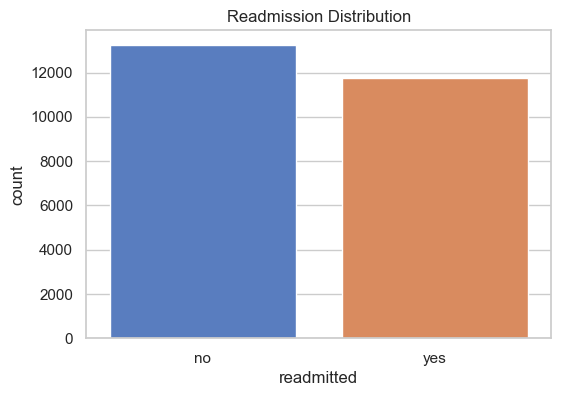

In [8]:
fig = plt.figure(figsize=(6,4))
sns.countplot(x="readmitted", data=df, palette="muted")
plt.title("Readmission Distribution")
save_plot(fig, "readmission_distribution.png")


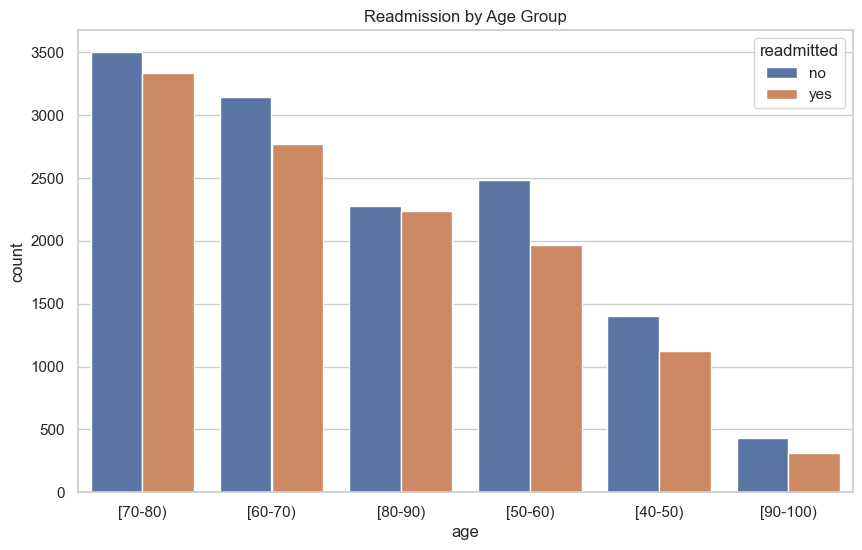

In [9]:
fig = plt.figure(figsize=(10,6))
sns.countplot(x="age", hue="readmitted", data=df, order=df["age"].value_counts().index)
plt.title("Readmission by Age Group")
save_plot(fig, "readmission_by_age.png")


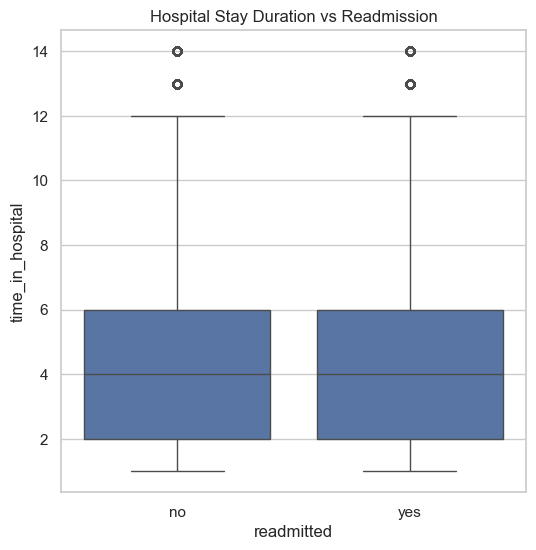

In [10]:
fig = plt.figure(figsize=(6,6))
sns.boxplot(x="readmitted", y="time_in_hospital", data=df)
plt.title("Hospital Stay Duration vs Readmission")
save_plot(fig, "hospital_stay_vs_readmission.png")

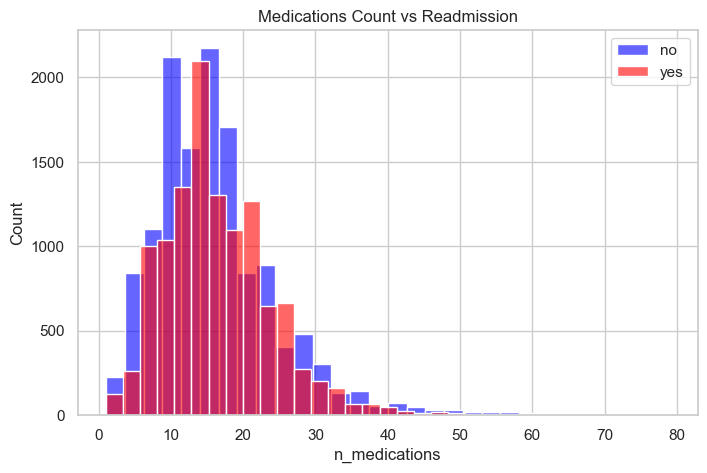

In [11]:
fig = plt.figure(figsize=(8,5))
sns.histplot(df[df['readmitted']=="no"]["n_medications"], bins=30, color="blue", label="no", alpha=0.6)
sns.histplot(df[df['readmitted']=="yes"]["n_medications"], bins=30, color="red", label="yes", alpha=0.6)
plt.legend()
plt.title("Medications Count vs Readmission")
save_plot(fig, "medications_vs_readmission.png")

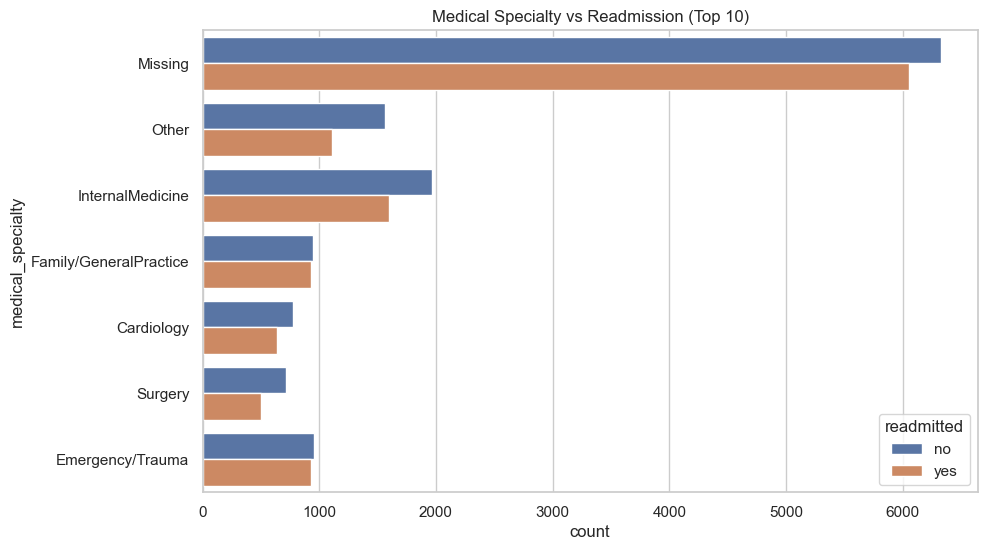

In [12]:
fig = plt.figure(figsize=(10,6))
top_specs = df["medical_specialty"].value_counts().nlargest(10).index
sns.countplot(y="medical_specialty", hue="readmitted", data=df[df["medical_specialty"].isin(top_specs)])
plt.title("Medical Specialty vs Readmission (Top 10)")
save_plot(fig, "medical_specialty_vs_readmission.png")

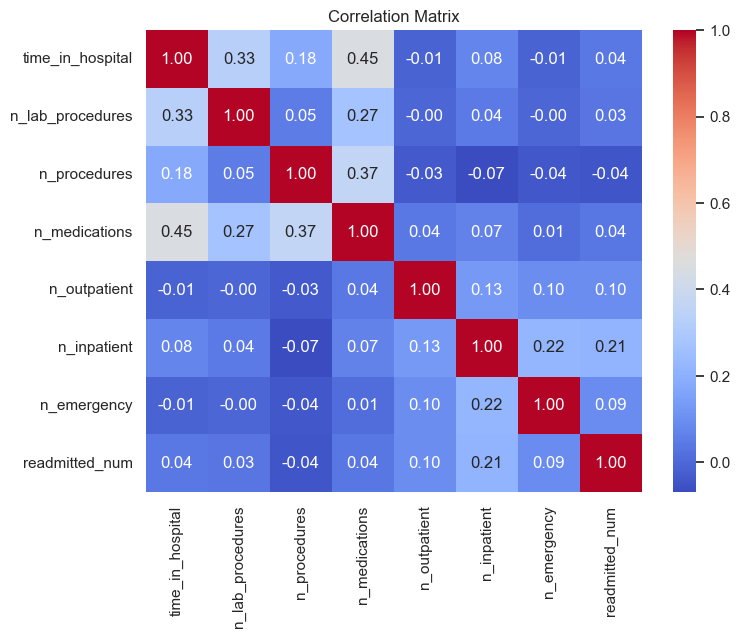

In [13]:
fig = plt.figure(figsize=(8,6))
corr = df[num_cols + ["readmitted_num"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
save_plot(fig, "correlation_matrix.png")

In [14]:
summary = df.groupby("readmitted")[num_cols].mean().round(2)
print("=== Average values by Readmission ===")
print(summary)

=== Average values by Readmission ===
            time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
readmitted                                                                    
no                      4.33             42.63          1.42          15.97   
yes                     4.59             43.93          1.27          16.57   

            n_outpatient  n_inpatient  n_emergency  
readmitted                                          
no                  0.26         0.38         0.11  
yes                 0.49         0.88         0.27  
